<a href="https://colab.research.google.com/github/kevinball02/HUFS-ML-Project/blob/master/image_classification_kyh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Image Classification: Carrots vs Rockets

### Import Libraries

In [2]:
# 관련 Notebook에서 호출한 library 사용. + warnings 추가, train_test_split 제거
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.applications.efficientnet import *

### Download Dataset

In [3]:
!git clone 'https://github.com/kevinball02/HUFS-ML-Project.git'

!mkdir -p ~/.kaggle
!mkdir -p ./result
!mv HUFS-ML-Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Cloning into 'HUFS-ML-Project'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 153 (delta 30), reused 0 (delta 0), pack-reused 88
Receiving objects: 100% (153/153), 7.48 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [4]:
!kaggle datasets download -d mikoajfish99/carrots-vs-rockets-image-classification
!unzip carrots-vs-rockets-image-classification.zip

 98% 88.0M/90.2M [00:06<00:00, 15.4MB/s]
100% 90.2M/90.2M [00:06<00:00, 14.0MB/s]
Archive:  carrots-vs-rockets-image-classification.zip
  inflating: Images/Carrots/000333bbb9b7ae4c.jpg  
  inflating: Images/Carrots/0022d08b808c7af6.jpg  
  inflating: Images/Carrots/002469afe027814c.jpg  
  inflating: Images/Carrots/004bdf076237f2fb.jpg  
  inflating: Images/Carrots/00714e843dcac5e3.jpg  
  inflating: Images/Carrots/007c1d785782989c.jpg  
  inflating: Images/Carrots/00b69a01ddc58eaf.jpg  
  inflating: Images/Carrots/00ce3578cf700c14.jpg  
  inflating: Images/Carrots/0107069d8e6d0490.jpg  
  inflating: Images/Carrots/0177c759a586204e.jpg  
  inflating: Images/Carrots/01b32dadf81ac313.jpg  
  inflating: Images/Carrots/02195c0230ff7cb8.jpg  
  inflating: Images/Carrots/028711cdda533c78.jpg  
  inflating: Images/Carrots/02924ae5412e1165.jpg  
  inflating: Images/Carrots/02fdcb9074408b91.jpg  
  inflating: Images/Carrots/030c8ab76561d5b0.jpg  
  inflating: Images/Carrots/0313d19eb780e21f.jpg

In [5]:
image_dir = Path('./Images')
# 압축 해제 했으므로 Images 파일이 현재 디렉토리에 생성됨.

In [6]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df

,Filepath,Label
0,Images/Rockets/0c43ca8f6be15219.jpg,Rockets
1,Images/Rockets/31bfe96b08763399.jpg,Rockets
2,Images/Rockets/09c91bdf782b7db9.jpg,Rockets
3,Images/Rockets/65ab2ab3a64189b7.jpg,Rockets
4,Images/Rockets/c07a5edc482ddf67.jpg,Rockets
...,...,...
301,Images/Carrots/028711cdda533c78.jpg,Carrots
302,Images/Carrots/0820b0c10650d4b8.jpg,Carrots
303,Images/Carrots/615640685695427e.jpg,Carrots
304,Images/Carrots/51eccd06672fed12.jpg,Carrots


In [8]:
image_df = image_df.sample(frac=1).reset_index(drop = True) # shuffle과 동일한 역할 수행

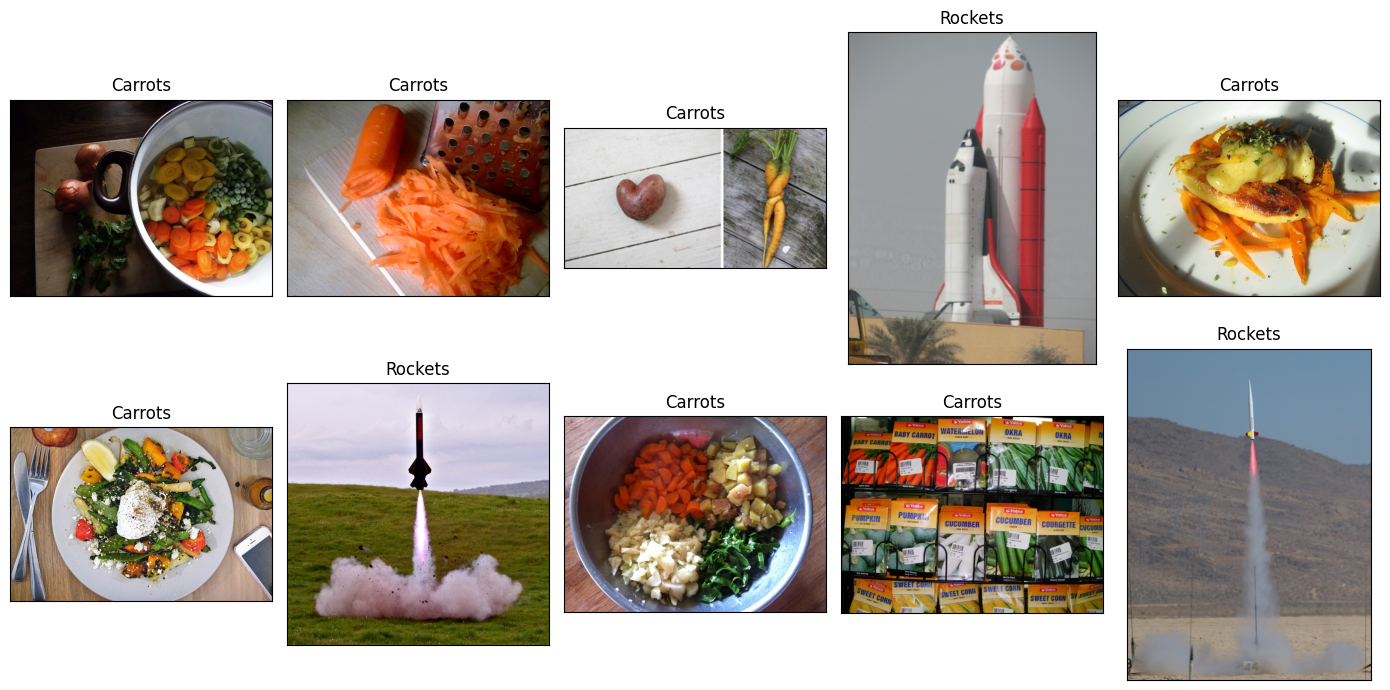

In [24]:
# 자료 시각화
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

image 갯수가 300여개로 적으므로, train/val 분할만 진행하겠다.

## I. Simple CNN

In [10]:
# 이미지를 증강하는 생성자 정의
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,   # 수평 반전
    rotation_range=40,      # 회전 각도
    width_shift_range=0.2,
    height_shift_range=0.2, # 폭, 높이 변동
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.1    # train/val 비율 설정
)

In [11]:
# 생성자에 데이터를 넣어 train/val 분할. + 세부 설정
train_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 276 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


In [12]:
# train set 클래스 확인
train_images.class_indices

{'Carrots': 0, 'Rockets': 1}

In [13]:
# cnn 모델 생성
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(2,2)(x)

x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 256)               100933888 
                                                             

In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
checkpoint_path = 'models/models/MyCNN.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=6, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [17]:
# 모델 훈련
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 16.8843 - accuracy: 0.5543
Epoch 1: val_loss improved from inf to 1.64087, saving model to models/models/MyCNN.h5
9/9 [==============================] - 22s 1s/step - loss: 16.8843 - accuracy: 0.5543 - val_loss: 1.6409 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 1.6796 - accuracy: 0.8225
Epoch 2: val_loss did not improve from 1.64087
9/9 [==============================] - 8s 941ms/step - loss: 1.6796 - accuracy: 0.8225 - val_loss: 3.9762 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 1.7179 - accuracy: 0.8333
Epoch 3: val_loss improved from 1.64087 to 1.41975, saving model to models/models/MyCNN.h5
9/9 [==============================] - 11s 1s/step - loss: 1.7179 - accuracy: 0.8333 - val_loss: 1.4198 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 1.0643 - 

## II. Transfer Learning (VGG16)

In [18]:
from keras.applications import VGG16

vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# VGG16의 classification layer를 배제하고 호출
output = vgg.output

y = GlobalAveragePooling2D()(output)
y = Dense(256, activation='relu')(y)
output = Dense(2, activation='softmax', name='output')(y)

model = Model(inputs=vgg.input, outputs=output)

58889256/58889256 [==============================] - 4s 0us/step


In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [20]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
checkpoint_path = 'models/models/MyTransModel.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=6, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [22]:
# transfer model 학습
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 2.3344 - accuracy: 0.4746
Epoch 1: val_loss improved from inf to 0.69543, saving model to models/models/MyTransModel.h5
9/9 [==============================] - 36s 3s/step - loss: 2.3344 - accuracy: 0.4746 - val_loss: 0.6954 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.4058
Epoch 2: val_loss did not improve from 0.69543
9/9 [==============================] - 7s 737ms/step - loss: 0.7358 - accuracy: 0.4058 - val_loss: 0.6962 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.5109
Epoch 3: val_loss improved from 0.69543 to 0.65577, saving model to models/models/MyTransModel.h5
9/9 [==============================] - 8s 909ms/step - loss: 0.6832 - accuracy: 0.5109 - val_loss: 0.6558 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
9/9 [==============================] - ETA: 0s - l